# AeroGuard RUL - Jet Engine Health Monitoring

CNN-LSTM model for Remaining Useful Life prediction using NASA C-MAPSS FD001 dataset.

## 1. Install Dependencies

In [ ]:
# Uncomment and run if packages are not installed
# !pip install pandas numpy tensorflow scikit-learn matplotlib plotly

## 2. Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 3. Configuration

In [3]:
# Dataset path
DATA_DIR = '../datasets/CMAPSSData'
MODEL_DIR = '../models'

# Column names
COLUMN_NAMES = ['unit', 'time'] + [f'op{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]

# Sensors to drop (constant values)
SENSORS_TO_DROP = ['sensor1', 'sensor5', 'sensor10', 'sensor16', 'sensor18', 'sensor19', 'op3']

# Hyperparameters
MAX_RUL_CAP = 125
SEQUENCE_LENGTH = 30
EPOCHS = 100
BATCH_SIZE = 256

os.makedirs(MODEL_DIR, exist_ok=True)

## 4. Load Data

In [4]:
# Load datasets
train_df = pd.read_csv(f'{DATA_DIR}/train_FD001.txt', sep=r'\s+', header=None, names=COLUMN_NAMES)
test_df = pd.read_csv(f'{DATA_DIR}/test_FD001.txt', sep=r'\s+', header=None, names=COLUMN_NAMES)
rul_df = pd.read_csv(f'{DATA_DIR}/RUL_FD001.txt', header=None, names=['RUL'])

print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"RUL labels: {rul_df.shape}")
train_df.head()

Training data: (20631, 26)
Test data: (13096, 26)
RUL labels: (100, 1)


,unit,time,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 5. Data Preprocessing

In [5]:
def add_rul_labels(df, max_rul_cap=MAX_RUL_CAP):
    """Add RUL labels with piecewise linear capping."""
    df = df.copy()
    rul_list = []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit]
        max_cycle = unit_df['time'].max()
        rul = max_cycle - unit_df['time']
        rul_list.extend(rul.tolist())
    df['RUL'] = rul_list
    df['RUL'] = df['RUL'].clip(upper=max_rul_cap)
    return df

# Add RUL labels to training data
train_df = add_rul_labels(train_df)
print("RUL distribution:")
train_df['RUL'].describe()

RUL distribution:


count    20631.000000
mean        86.829286
std         41.673699
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL, dtype: float64

In [6]:
# Drop constant sensors
cols_to_drop = [col for col in SENSORS_TO_DROP if col in train_df.columns]
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

print(f"Remaining columns: {list(train_df.columns)}")

Remaining columns: ['unit', 'time', 'op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21', 'RUL']


In [7]:
# Get feature columns
feature_cols = [col for col in train_df.columns if col.startswith('sensor') or col.startswith('op')]
print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

# Normalize data
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

Feature columns (17): ['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21']


In [8]:
def create_sequences(df, sequence_length, is_test=False):
    """Create 3D sequences for CNN-LSTM."""
    sequences, labels, engine_ids = [], [], []
    
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].sort_values('time')
        data = unit_df[feature_cols].values
        
        if is_test:
            if len(data) >= sequence_length:
                sequences.append(data[-sequence_length:])
                engine_ids.append(unit)
        else:
            rul_values = unit_df['RUL'].values
            for i in range(len(data) - sequence_length + 1):
                sequences.append(data[i:i + sequence_length])
                labels.append(rul_values[i + sequence_length - 1])
                engine_ids.append(unit)
    
    X = np.array(sequences)
    if is_test:
        return X, np.array(engine_ids)
    return X, np.array(labels), np.array(engine_ids)

# Create sequences
X_train, y_train, train_ids = create_sequences(train_df, SEQUENCE_LENGTH, is_test=False)
X_test, test_ids = create_sequences(test_df, SEQUENCE_LENGTH, is_test=True)
y_test = rul_df['RUL'].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (17731, 30, 17)
y_train shape: (17731,)
X_test shape: (100, 30, 17)
y_test shape: (100,)


In [9]:
# Train/validation split
val_split = int(0.8 * len(X_train))
X_val, y_val = X_train[val_split:], y_train[val_split:]
X_train, y_train = X_train[:val_split], y_train[:val_split]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 14184
Validation samples: 3547
Test samples: 100


## 6. Build CNN-LSTM Model

In [10]:
def build_model(input_shape):
    """Build CNN-LSTM hybrid architecture."""
    model = Sequential([
        # CNN for spatial features
        Conv1D(filters=64, kernel_size=3, activation='relu', 
               input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=2),
        
        # LSTM for temporal patterns
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        
        # Output
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

c:\Users\User\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,579 (388.98 KB)

 Trainable params: 99,579 (388.98 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Train Model

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f'{MODEL_DIR}/cnn_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 7335.0278 - mae: 74.8928
Epoch 1: val_loss improved from None to 7043.28516, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - loss: 6897.1924 - mae: 72.2389 - val_loss: 7043.2852 - val_mae: 73.3423 - learning_rate: 0.0010
Epoch 2/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 6241.3169 - mae: 68.0241
Epoch 2: val_loss improved from 7043.28516 to 6603.27295, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 6176.8374 - mae: 67.6930 - val_loss: 6603.2729 - val_mae: 70.6969 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5883.5513 - mae: 66.0204
Epoch 3: val_loss improved from 6603.27295 to 6215.56494, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 5791.9370 - mae: 65.2677 - val_loss: 6215.5649 - val_mae: 68.3551 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 5469.6323 - mae: 63.1900
Epoch 4: val_loss improved from 6215.56494 to 5858.60352, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 5443.2285 - mae: 63.0222 - val_loss: 5858.6035 - val_mae: 66.1882 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 5216.4351 - mae: 61.6703
Epoch 5: val_loss improved from 5858.60352 to 5527.82422, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 5126.2051 - mae: 61.0022 - val_loss: 5527.8242 - val_mae: 64.1695 - learning_rate: 0.0010
Epoch 6/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 4911.2456 - mae: 59.5725
Epoch 6: val_loss improved from 5527.82422 to 5219.48535, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 4832.7710 - mae: 59.1040 - val_loss: 5219.4854 - val_mae: 62.2795 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 4554.7471 - mae: 57.1180
Epoch 7: val_loss improved from 5219.48535 to 4933.97705, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 4555.7803 - mae: 57.3128 - val_loss: 4933.9771 - val_mae: 60.5175 - learning_rate: 0.0010
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 4336.8076 - mae: 55.9573
Epoch 8: val_loss improved from 4933.97705 to 4666.65479, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 4300.1074 - mae: 55.6575 - val_loss: 4666.6548 - val_mae: 58.8602 - learning_rate: 0.0010
Epoch 9/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 4105.0078 - mae: 54.2520
Epoch 9: val_loss improved from 4666.65479 to 4419.30371, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 4069.5388 - mae: 54.1456 - val_loss: 4419.3037 - val_mae: 57.3132 - learning_rate: 0.0010
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 3907.6982 - mae: 53.1038
Epoch 10: val_loss improved from 4419.30371 to 4187.12988, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3845.8110 - mae: 52.6700 - val_loss: 4187.1299 - val_mae: 55.8481 - learning_rate: 0.0010
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3706.7253 - mae: 51.7788
Epoch 11: val_loss improved from 4187.12988 to 3972.85474, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 3642.7339 - mae: 51.3271 - val_loss: 3972.8547 - val_mae: 54.4846 - learning_rate: 0.0010
Epoch 12/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3498.5051 - mae: 50.3468
Epoch 12: val_loss improved from 3972.85474 to 3774.04126, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 3454.6902 - mae: 50.0390 - val_loss: 3774.0413 - val_mae: 53.2060 - learning_rate: 0.0010
Epoch 13/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3338.2449 - mae: 49.3016
Epoch 13: val_loss improved from 3774.04126 to 3589.63574, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 3282.8159 - mae: 48.8950 - val_loss: 3589.6357 - val_mae: 52.0091 - learning_rate: 0.0010
Epoch 14/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 3194.5095 - mae: 48.4000
Epoch 14: val_loss improved from 3589.63574 to 3419.42383, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3123.2896 - mae: 47.8130 - val_loss: 3419.4238 - val_mae: 50.8914 - learning_rate: 0.0010
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3028.0798 - mae: 47.2773
Epoch 15: val_loss improved from 3419.42383 to 3262.81860, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 2979.8074 - mae: 46.8417 - val_loss: 3262.8186 - val_mae: 49.8513 - learning_rate: 0.0010
Epoch 16/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2894.4355 - mae: 46.2380
Epoch 16: val_loss improved from 3262.81860 to 3118.25171, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 2852.0540 - mae: 45.9432 - val_loss: 3118.2517 - val_mae: 48.8773 - learning_rate: 0.0010
Epoch 17/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 2756.9302 - mae: 45.2745
Epoch 17: val_loss improved from 3118.25171 to 2985.42847, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 2724.1694 - mae: 45.0333 - val_loss: 2985.4285 - val_mae: 47.9747 - learning_rate: 0.0010
Epoch 18/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 2651.2156 - mae: 44.5409
Epoch 18: val_loss improved from 2985.42847 to 2864.28076, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 2617.2896 - mae: 44.2834 - val_loss: 2864.2808 - val_mae: 47.1378 - learning_rate: 0.0010
Epoch 19/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 2501.2466 - mae: 43.3611
Epoch 19: val_loss improved from 2864.28076 to 2753.19067, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 2518.1277 - mae: 43.5926 - val_loss: 2753.1907 - val_mae: 46.3590 - learning_rate: 0.0010
Epoch 20/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2438.9622 - mae: 42.9554
Epoch 20: val_loss improved from 2753.19067 to 2651.17798, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 2423.8447 - mae: 42.9258 - val_loss: 2651.1780 - val_mae: 45.6342 - learning_rate: 0.0010
Epoch 21/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 2376.5283 - mae: 42.6382
Epoch 21: val_loss improved from 2651.17798 to 2559.00049, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 2347.5320 - mae: 42.3736 - val_loss: 2559.0005 - val_mae: 44.9675 - learning_rate: 0.0010
Epoch 22/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 2301.2136 - mae: 42.0570
Epoch 22: val_loss improved from 2559.00049 to 2474.62598, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 2270.8555 - mae: 41.8296 - val_loss: 2474.6260 - val_mae: 44.3469 - learning_rate: 0.0010
Epoch 23/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 2206.2422 - mae: 41.2799
Epoch 23: val_loss improved from 2474.62598 to 2398.64087, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 2198.7915 - mae: 41.2330 - val_loss: 2398.6409 - val_mae: 43.7778 - learning_rate: 0.0010
Epoch 24/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 2163.0195 - mae: 40.9323
Epoch 24: val_loss improved from 2398.64087 to 2330.91235, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - loss: 2152.8269 - mae: 40.9157 - val_loss: 2330.9124 - val_mae: 43.2610 - learning_rate: 0.0010
Epoch 25/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 2117.4304 - mae: 40.6552
Epoch 25: val_loss improved from 2330.91235 to 2268.40601, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - loss: 2090.4604 - mae: 40.4069 - val_loss: 2268.4060 - val_mae: 42.7731 - learning_rate: 0.0010
Epoch 26/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2066.9407 - mae: 40.2606
Epoch 26: val_loss improved from 2268.40601 to 2213.00293, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 2043.7124 - mae: 40.0605 - val_loss: 2213.0029 - val_mae: 42.3332 - learning_rate: 0.0010
Epoch 27/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2023.7882 - mae: 39.9407
Epoch 27: val_loss improved from 2213.00293 to 2162.85425, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 2013.7593 - mae: 39.8162 - val_loss: 2162.8542 - val_mae: 41.9253 - learning_rate: 0.0010
Epoch 28/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1963.8202 - mae: 39.3573
Epoch 28: val_loss improved from 2162.85425 to 2118.64014, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 1967.5183 - mae: 39.4027 - val_loss: 2118.6401 - val_mae: 41.5567 - learning_rate: 0.0010
Epoch 29/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1940.5902 - mae: 39.2040
Epoch 29: val_loss improved from 2118.64014 to 2079.50146, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 1938.7708 - mae: 39.1728 - val_loss: 2079.5015 - val_mae: 41.2224 - learning_rate: 0.0010
Epoch 30/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1907.9142 - mae: 38.8652
Epoch 30: val_loss improved from 2079.50146 to 2043.06665, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 1911.2794 - mae: 38.9026 - val_loss: 2043.0667 - val_mae: 40.9029 - learning_rate: 0.0010
Epoch 31/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 1884.5663 - mae: 38.6256
Epoch 31: val_loss improved from 2043.06665 to 1964.32312, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - loss: 1872.4753 - mae: 38.5175 - val_loss: 1964.3231 - val_mae: 40.1038 - learning_rate: 0.0010
Epoch 32/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 1810.8314 - mae: 37.9194
Epoch 32: val_loss improved from 1964.32312 to 1877.63391, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - loss: 1793.1025 - mae: 37.7103 - val_loss: 1877.6339 - val_mae: 39.1939 - learning_rate: 0.0010
Epoch 33/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1736.1394 - mae: 37.0756
Epoch 33: val_loss improved from 1877.63391 to 1635.79663, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - loss: 1673.9669 - mae: 36.3325 - val_loss: 1635.7966 - val_mae: 36.2453 - learning_rate: 0.0010
Epoch 34/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 1367.1982 - mae: 31.8776
Epoch 34: val_loss improved from 1635.79663 to 1334.09631, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 1283.5010 - mae: 30.2561 - val_loss: 1334.0963 - val_mae: 30.9793 - learning_rate: 0.0010
Epoch 35/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1136.9762 - mae: 27.3646
Epoch 35: val_loss improved from 1334.09631 to 1240.59412, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 1115.8042 - mae: 27.0471 - val_loss: 1240.5941 - val_mae: 29.7789 - learning_rate: 0.0010
Epoch 36/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 1056.5270 - mae: 26.3891
Epoch 36: val_loss improved from 1240.59412 to 1098.32910, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 1028.4056 - mae: 25.8222 - val_loss: 1098.3291 - val_mae: 27.2820 - learning_rate: 0.0010
Epoch 37/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 958.2728 - mae: 24.6654
Epoch 37: val_loss improved from 1098.32910 to 1032.30786, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 933.4356 - mae: 24.2539 - val_loss: 1032.3079 - val_mae: 26.6407 - learning_rate: 0.0010
Epoch 38/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 870.2422 - mae: 23.2361
Epoch 38: val_loss improved from 1032.30786 to 945.93713, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 848.5824 - mae: 22.9386 - val_loss: 945.9371 - val_mae: 25.2570 - learning_rate: 0.0010
Epoch 39/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 823.1731 - mae: 22.7442
Epoch 39: val_loss improved from 945.93713 to 863.60889, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - loss: 794.3364 - mae: 22.2522 - val_loss: 863.6089 - val_mae: 23.8584 - learning_rate: 0.0010
Epoch 40/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 739.4038 - mae: 21.3083
Epoch 40: val_loss improved from 863.60889 to 805.22986, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 729.9712 - mae: 21.2107 - val_loss: 805.2299 - val_mae: 23.1807 - learning_rate: 0.0010
Epoch 41/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 707.3793 - mae: 21.1783
Epoch 41: val_loss improved from 805.22986 to 749.69690, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 691.4731 - mae: 20.8461 - val_loss: 749.6969 - val_mae: 22.5225 - learning_rate: 0.0010
Epoch 42/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 651.0473 - mae: 20.1612
Epoch 42: val_loss improved from 749.69690 to 703.15588, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 637.3953 - mae: 19.9458 - val_loss: 703.1559 - val_mae: 21.5167 - learning_rate: 0.0010
Epoch 43/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 611.2661 - mae: 19.5325
Epoch 43: val_loss improved from 703.15588 to 645.74756, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 596.6284 - mae: 19.3016 - val_loss: 645.7476 - val_mae: 20.8689 - learning_rate: 0.0010
Epoch 44/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 566.9507 - mae: 18.8638
Epoch 44: val_loss improved from 645.74756 to 602.40521, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 555.1987 - mae: 18.6141 - val_loss: 602.4052 - val_mae: 20.1343 - learning_rate: 0.0010
Epoch 45/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 528.5088 - mae: 18.2468
Epoch 45: val_loss improved from 602.40521 to 579.26373, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 520.9792 - mae: 18.1554 - val_loss: 579.2637 - val_mae: 19.8074 - learning_rate: 0.0010
Epoch 46/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 500.2306 - mae: 17.7034
Epoch 46: val_loss improved from 579.26373 to 535.29358, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 249ms/step - loss: 490.6111 - mae: 17.5423 - val_loss: 535.2936 - val_mae: 19.0045 - learning_rate: 0.0010
Epoch 47/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 466.5385 - mae: 17.1618
Epoch 47: val_loss improved from 535.29358 to 497.70743, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - loss: 463.0027 - mae: 17.1239 - val_loss: 497.7074 - val_mae: 18.3876 - learning_rate: 0.0010
Epoch 48/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 437.6449 - mae: 16.5890
Epoch 48: val_loss improved from 497.70743 to 461.86957, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - loss: 434.7187 - mae: 16.6085 - val_loss: 461.8696 - val_mae: 17.8975 - learning_rate: 0.0010
Epoch 49/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 412.8718 - mae: 16.2547
Epoch 49: val_loss improved from 461.86957 to 443.97568, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 407.8129 - mae: 16.1266 - val_loss: 443.9757 - val_mae: 17.5577 - learning_rate: 0.0010
Epoch 50/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 391.2323 - mae: 15.8005
Epoch 50: val_loss improved from 443.97568 to 430.67630, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - loss: 390.2339 - mae: 15.8031 - val_loss: 430.6763 - val_mae: 17.1931 - learning_rate: 0.0010
Epoch 51/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 383.6534 - mae: 15.6629
Epoch 51: val_loss improved from 430.67630 to 430.37881, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 377.5789 - mae: 15.5250 - val_loss: 430.3788 - val_mae: 17.1954 - learning_rate: 0.0010
Epoch 52/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 360.0434 - mae: 15.0820
Epoch 52: val_loss improved from 430.37881 to 384.77237, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 361.4748 - mae: 15.1843 - val_loss: 384.7724 - val_mae: 16.4408 - learning_rate: 0.0010
Epoch 53/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 345.5219 - mae: 14.8555
Epoch 53: val_loss improved from 384.77237 to 349.59457, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 334.4921 - mae: 14.5767 - val_loss: 349.5946 - val_mae: 15.6403 - learning_rate: 0.0010
Epoch 54/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 312.7072 - mae: 14.0380
Epoch 54: val_loss improved from 349.59457 to 336.53436, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 317.2684 - mae: 14.2005 - val_loss: 336.5344 - val_mae: 15.4327 - learning_rate: 0.0010
Epoch 55/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 308.8832 - mae: 13.9787
Epoch 55: val_loss improved from 336.53436 to 335.31070, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 314.7837 - mae: 14.1598 - val_loss: 335.3107 - val_mae: 15.4422 - learning_rate: 0.0010
Epoch 56/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 317.3946 - mae: 14.2920
Epoch 56: val_loss improved from 335.31070 to 314.51587, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 306.9134 - mae: 14.0084 - val_loss: 314.5159 - val_mae: 14.8626 - learning_rate: 0.0010
Epoch 57/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 291.1565 - mae: 13.6146
Epoch 57: val_loss did not improve from 314.51587
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 285.3563 - mae: 13.4205 - val_loss: 346.9841 - val_mae: 15.4419 - learning_rate: 0.0010
Epoch 58/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 292.5072 - mae: 13.5973
Epoch 58: val_loss improved from 314.51587 to 284.65582, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 279.0360 - mae: 13.2649 - val_loss: 284.6558 - val_mae: 14.0963 - learning_rate: 0.0010
Epoch 59/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 268.1300 - mae: 12.8920
Epoch 59: val_loss improved from 284.65582 to 277.67920, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 265.3023 - mae: 12.8875 - val_loss: 277.6792 - val_mae: 14.0629 - learning_rate: 0.0010
Epoch 60/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 260.4449 - mae: 12.7999
Epoch 60: val_loss improved from 277.67920 to 267.66547, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 260.2683 - mae: 12.8097 - val_loss: 267.6655 - val_mae: 13.7016 - learning_rate: 0.0010
Epoch 61/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 255.6905 - mae: 12.7218
Epoch 61: val_loss improved from 267.66547 to 258.96249, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 247.6873 - mae: 12.4497 - val_loss: 258.9625 - val_mae: 13.3840 - learning_rate: 0.0010
Epoch 62/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 246.8366 - mae: 12.3303
Epoch 62: val_loss improved from 258.96249 to 245.05771, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 242.2615 - mae: 12.2591 - val_loss: 245.0577 - val_mae: 13.0860 - learning_rate: 0.0010
Epoch 63/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 237.8006 - mae: 12.1018
Epoch 63: val_loss improved from 245.05771 to 236.79636, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 237.5306 - mae: 12.1165 - val_loss: 236.7964 - val_mae: 12.8561 - learning_rate: 0.0010
Epoch 64/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 225.0571 - mae: 11.7163
Epoch 64: val_loss improved from 236.79636 to 229.30450, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 223.2380 - mae: 11.6969 - val_loss: 229.3045 - val_mae: 12.7048 - learning_rate: 0.0010
Epoch 65/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 231.6475 - mae: 11.9841
Epoch 65: val_loss improved from 229.30450 to 221.92407, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 230.8441 - mae: 11.8920 - val_loss: 221.9241 - val_mae: 12.3454 - learning_rate: 0.0010
Epoch 66/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 217.7969 - mae: 11.4432
Epoch 66: val_loss did not improve from 221.92407
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 216.1247 - mae: 11.4172 - val_loss: 241.1381 - val_mae: 12.5383 - learning_rate: 0.0010
Epoch 67/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 210.3029 - mae: 11.2118
Epoch 67: val_loss did not improve from 221.92407
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 216.5919 - mae: 11.3643 - val_loss: 223.1423 - val_mae: 12.2201 - learning_rate: 0.0010
Epoch 68/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 217.7412 - mae: 11.4001
Epoch 68: val_loss improved from 221.92407 to 219.32176, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - loss: 214.3277 - mae: 11.3043 - val_loss: 219.3218 - val_mae: 11.9425 - learning_rate: 0.0010
Epoch 69/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 214.6528 - mae: 11.2535
Epoch 69: val_loss improved from 219.32176 to 215.64922, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - loss: 208.7656 - mae: 11.0807 - val_loss: 215.6492 - val_mae: 11.8748 - learning_rate: 0.0010
Epoch 70/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 205.1395 - mae: 10.9872
Epoch 70: val_loss improved from 215.64922 to 211.53542, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 203.9455 - mae: 10.9010 - val_loss: 211.5354 - val_mae: 11.9079 - learning_rate: 0.0010
Epoch 71/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 207.8380 - mae: 11.0686
Epoch 71: val_loss improved from 211.53542 to 205.70465, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 203.3184 - mae: 10.9461 - val_loss: 205.7047 - val_mae: 11.5422 - learning_rate: 0.0010
Epoch 72/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 199.2958 - mae: 10.7604
Epoch 72: val_loss did not improve from 205.70465
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - loss: 198.7543 - mae: 10.7319 - val_loss: 206.0271 - val_mae: 11.5035 - learning_rate: 0.0010
Epoch 73/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 192.3680 - mae: 10.5619
Epoch 73: val_loss improved from 205.70465 to 197.47775, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - loss: 193.2182 - mae: 10.5577 - val_loss: 197.4778 - val_mae: 11.3516 - learning_rate: 0.0010
Epoch 74/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 190.1028 - mae: 10.4525
Epoch 74: val_loss improved from 197.47775 to 194.01643, saving model to ../models/cnn_lstm_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - loss: 192.3775 - mae: 10.5297 - val_loss: 194.0164 - val_mae: 11.1892 - learning_rate: 0.0010
Epoch 75/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 197.7717 - mae: 10.6252
Epoch 75: val_loss did not improve from 194.01643
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 193.0479 - mae: 10.4957 - val_loss: 212.1874 - val_mae: 11.4213 - learning_rate: 0.0010
Epoch 76/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 191.9292 - mae: 10.4670
Epoch 76: val_loss did not improve from 194.01643
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 185.3798 - mae: 10.2929 - val_loss: 198.6634 - val_mae: 11.1224 - learning_rate: 0.0010
Epoch 77/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 181.6240 - mae: 10.2208
Epoch 77: val_loss did not improve from 194.01643
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 184.6609 - mae: 10.2467 - val_loss: 210.7089 - val_mae: 11.3201 - learning_rate: 0.0010
Epoch 78/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0

56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 178.6944 - mae: 9.9731 - val_loss: 187.7289 - val_mae: 10.6662 - learning_rate: 5.0000e-04
Epoch 81/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 171.0683 - mae: 9.8096
Epoch 81: val_loss did not improve from 187.72894
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 172.8817 - mae: 9.8028 - val_loss: 192.3997 - val_mae: 10.7687 - learning_rate: 5.0000e-04
Epoch 82/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 172.6465 - mae: 9.8055
Epoch 82: val_loss did not improve from 187.72894
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 170.7304 - mae: 9.7962 - val_loss: 194.1463 - val_mae: 10.7159 - learning_rate: 5.0000e-04
Epoch 83/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 171.1526 - mae: 9.7980
Epoch 83: val_loss did not improve from 187.72894
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 171.8423 - mae: 9.7675 - val_loss: 227.6640 - val_mae: 11.4116 - learning_rate: 5.0000e-04
Epoch 84/100
55/56 ━━━━━━━━━━━━━━━━━

## 8. Training History

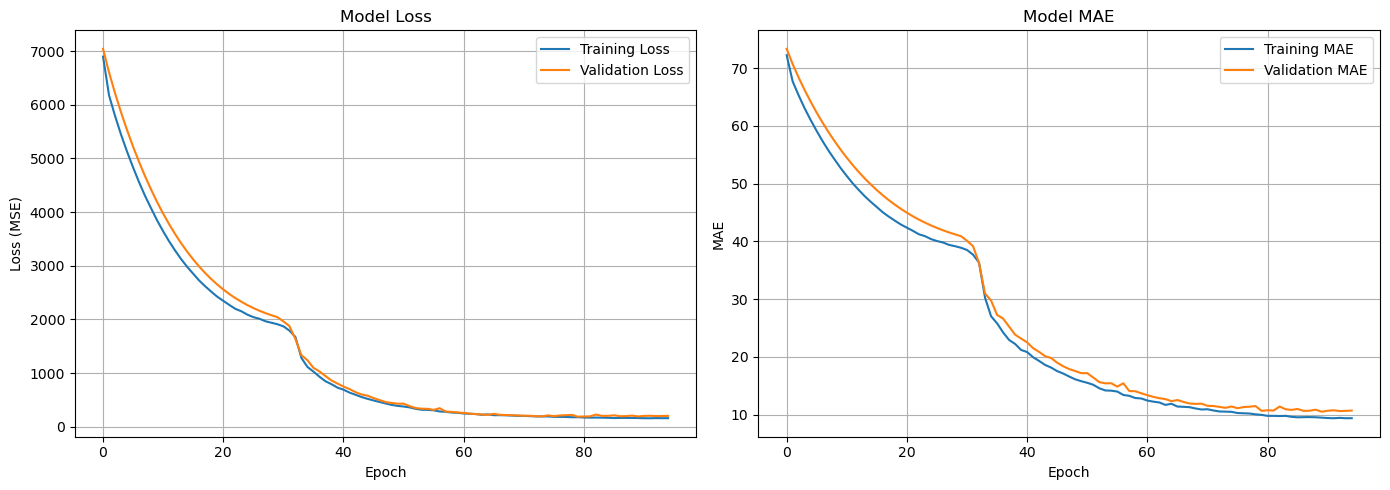

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 9. Evaluation

In [13]:
def calculate_rmse(y_true, y_pred):
    """Calculate RMSE."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_score(y_true, y_pred):
    """Calculate NASA S-Score."""
    d = y_pred - y_true
    score = 0
    for di in d:
        if di < 0:
            score += np.exp(-di / 13) - 1
        else:
            score += np.exp(di / 10) - 1
    return score

# Predict
y_pred = model.predict(X_test, verbose=0).flatten()
y_pred = np.maximum(y_pred, 0)  # Non-negative

# Metrics
rmse = calculate_rmse(y_test, y_pred)
score = calculate_score(y_test, y_pred)

print("=" * 50)
print("EVALUATION RESULTS")
print("=" * 50)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test S-Score: {score:.4f}")
print("=" * 50)

EVALUATION RESULTS
Test RMSE: 14.8377
Test S-Score: 393.2172


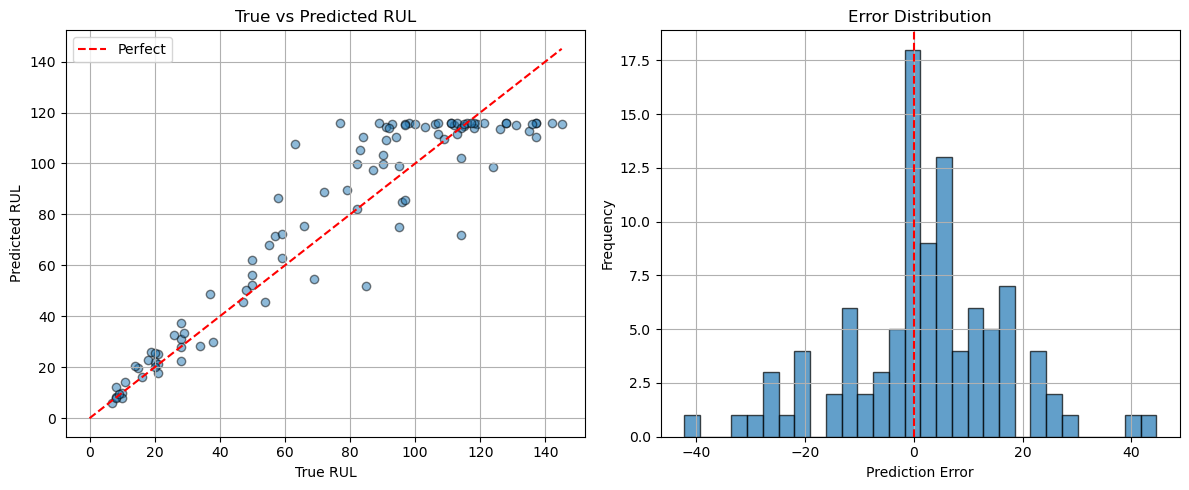

In [14]:
# Predictions vs Actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
errors = y_pred - y_test
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

## 10. Sample Predictions

## 11. Health Status Visualization

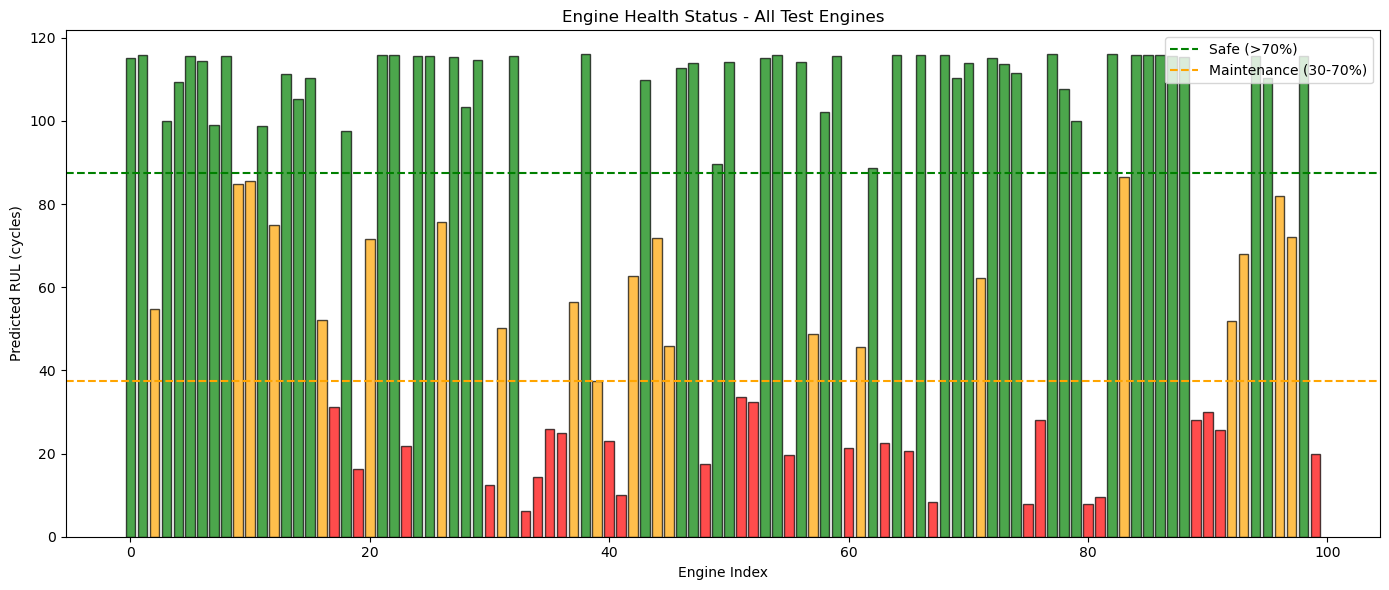


Health Distribution:
  Safe (Green): 53 engines
  Maintenance (Orange): 21 engines
  Critical (Red): 26 engines


In [16]:
# Color-coded predictions
colors = []
for pred in y_pred:
    health_pct = (pred / 125) * 100
    if health_pct > 70:
        colors.append('green')
    elif health_pct > 30:
        colors.append('orange')
    else:
        colors.append('red')

plt.figure(figsize=(14, 6))
plt.bar(range(len(y_pred)), y_pred, color=colors, edgecolor='k', alpha=0.7)
plt.axhline(y=87.5, color='green', linestyle='--', label='Safe (>70%)')
plt.axhline(y=37.5, color='orange', linestyle='--', label='Maintenance (30-70%)')
plt.xlabel('Engine Index')
plt.ylabel('Predicted RUL (cycles)')
plt.title('Engine Health Status - All Test Engines')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nHealth Distribution:")
print(f"  Safe (Green): {colors.count('green')} engines")
print(f"  Maintenance (Orange): {colors.count('orange')} engines")
print(f"  Critical (Red): {colors.count('red')} engines")

## 12. Save Model

In [17]:
import datetime

# Create timestamp for versioning
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Option 1: Save as H5 (Legacy format)
model.save(f'{MODEL_DIR}/cnn_lstm_model.h5')
print(f"Saved: {MODEL_DIR}/cnn_lstm_model.h5")

# Option 2: Save as Keras format (Recommended)
model.save(f'{MODEL_DIR}/cnn_lstm_model.keras')
print(f"Saved: {MODEL_DIR}/cnn_lstm_model.keras")

# Option 3: Save with timestamp for versioning
model.save(f'{MODEL_DIR}/cnn_lstm_model_{timestamp}.keras')
print(f"Saved: {MODEL_DIR}/cnn_lstm_model_{timestamp}.keras")

# Option 4: Save weights only
model.save_weights(f'{MODEL_DIR}/model_weights.weights.h5')
print(f"Saved: {MODEL_DIR}/model_weights.weights.h5")

print("\n All models saved successfully!")

Saved: ../models/cnn_lstm_model.h5
Saved: ../models/cnn_lstm_model.keras
Saved: ../models/cnn_lstm_model_20260114_042106.keras
Saved: ../models/model_weights.weights.h5

 All models saved successfully!


## 13. Load Saved Model

In [18]:
# Load a previously saved model
loaded_model = load_model(f'{MODEL_DIR}/cnn_lstm_model.h5')
# OR: loaded_model = load_model(f'{MODEL_DIR}/cnn_lstm_model.keras')

print("Model loaded successfully!")
loaded_model.summary()

# Verify predictions match
y_pred_loaded = loaded_model.predict(X_test[:5], verbose=0).flatten()
print(f"\nSample predictions from loaded model: {np.round(y_pred_loaded, 2)}")

ValueError: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass